# Lecture 2: Spark Dataframes

Spark SQL is the Spark module dedicated to store and process structured datasets, e.g organized in columns such as Pandas Dataframes or Relational Databases tables. 

In Spark, structured datasets are referred to as Spark Dataframes, which anyway rely on the RDD way of storing and partitioning the data, but also provides richer optimizations under the hood.

As for the previous lecture, select the most appropriate variable based on where this notebook is run. 
If the docker cluster is used, the process of starting spark cluster can be skipped.

In [1]:
# set this variable with one of the following values

# -> 'local'
# -> 'docker_container'
# -> 'docker_cluster'

CLUSTER_TYPE ='docker_cluster'

## Start the cluster 

Environment variables need to be set only in the case of a local cluster

In [2]:
# set an enviromental variable

%env CLUSTER_TYPE $CLUSTER_TYPE

env: CLUSTER_TYPE=docker_cluster


In [2]:
if CLUSTER_TYPE=='local':
    import findspark
    findspark.init('/home/pazzini/work/courses/MAPD_B/MAPD-B/spark/spark-3.2.1-bin-hadoop3.2/')

In [3]:
%%script bash --no-raise-error

if [[ "$CLUSTER_TYPE" != "docker_cluster" ]]; then
    echo "Launching master and worker"
    
    # start master 
    $SPARK_HOME/sbin/start-master.sh --host localhost \
        --port 7077 --webui-port 8080
    
    # start worker
    $SPARK_HOME/sbin/start-worker.sh spark://localhost:7077 \
        --cores 2 --memory 2g
fi

Launching master and worker
starting org.apache.spark.deploy.master.Master, logging to /usr/bin/spark-3.2.1-bin-hadoop3.2/logs/spark--org.apache.spark.deploy.master.Master-1-26df49e83ea9.out
starting org.apache.spark.deploy.worker.Worker, logging to /usr/bin/spark-3.2.1-bin-hadoop3.2/logs/spark--org.apache.spark.deploy.worker.Worker-1-26df49e83ea9.out


## Create the Spark session

In [4]:
from pyspark.sql import SparkSession

if CLUSTER_TYPE in ['local', 'docker_container']:
    
    spark = SparkSession.builder \
        .master("spark://localhost:7077")\
        .appName("First spark application")\
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
        .getOrCreate()

elif CLUSTER_TYPE == 'docker_cluster':
    
    # use the provided master
    spark = SparkSession.builder \
        .master("spark://spark-master:7077")\
        .appName("First spark application")\
        .config("spark.executor.memory", "512m")\
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
        .getOrCreate()
    
spark

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/11 07:00:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
sc = spark.sparkContext
sc

<SparkContext master=spark://spark-master:7077 appName=First spark application>

## Creating a simple DataFrame

Spark DataFrame is already very similar to the Pandas DataFrame API, and it can be created in a multitude of possible ways:

- creating and appending a list of Rows (Spark objects for records) with an implicit schema definition
- creating and appending a list of Python tuples with a explicit schema definition
- importing a Pandas DataFrame

In [7]:
from datetime import date, datetime
from pyspark.sql import Row

df = spark.createDataFrame([
    Row(a=1, b=2., c='string1', d=date(2000, 1, 1), e=datetime(2000, 1, 1, 12, 0)),
    Row(a=2, b=3., c='string2', d=date(2000, 2, 1), e=datetime(2000, 1, 2, 12, 0)),
    Row(a=4, b=5., c='string3', d=date(2000, 3, 1), e=datetime(2000, 1, 3, 12, 0))
])
df

DataFrame[a: bigint, b: double, c: string, d: date, e: timestamp]

In [8]:
df = spark.createDataFrame([
    (1, 2., 'string1', date(2000, 1, 1), datetime(2000, 1, 1, 12, 0)),
    (2, 3., 'string2', date(2000, 2, 1), datetime(2000, 1, 2, 12, 0)),
    (3, 4., 'string3', date(2000, 3, 1), datetime(2000, 1, 3, 12, 0))
], schema='a long, b double, c string, d date, e timestamp')
df

DataFrame[a: bigint, b: double, c: string, d: date, e: timestamp]

In [9]:
import pandas as pd

pandas_df = pd.DataFrame({
    'a': [1, 2, 3],
    'b': [2., 3., 4.],
    'c': ['string1', 'string2', 'string3'],
    'd': [date(2000, 1, 1), date(2000, 2, 1), date(2000, 3, 1)],
    'e': [datetime(2000, 1, 1, 12, 0), datetime(2000, 1, 2, 12, 0), datetime(2000, 1, 3, 12, 0)]
})

df = spark.createDataFrame(pandas_df)
df

DataFrame[a: bigint, b: double, c: string, d: date, e: timestamp]

As in the case of the RDD, the mere creation of the DataFrame does not imply any work is submitted to the executors.
Whenever we ask Spark to retrieve something we instead trigger the execution of the jobs (as usual, subdivided in stages and tasks).

To visualize the content of a Spark DataFrame we have similar interfaces to Pandas:
- `DataFrame.show()` to visualize its content
- `DataFrame.printSchema()` to visualize the schema of the structured dataset

In [10]:
df.show()

+---+---+-------+----------+-------------------+
|  a|  b|      c|         d|                  e|
+---+---+-------+----------+-------------------+
|  1|2.0|string1|2000-01-01|2000-01-01 12:00:00|
|  2|3.0|string2|2000-02-01|2000-01-02 12:00:00|
|  3|4.0|string3|2000-03-01|2000-01-03 12:00:00|
+---+---+-------+----------+-------------------+



In [11]:
df.printSchema()

root
 |-- a: long (nullable = true)
 |-- b: double (nullable = true)
 |-- c: string (nullable = true)
 |-- d: date (nullable = true)
 |-- e: timestamp (nullable = true)



## Loading structured data

By default Spark can create a DataFrame from data stored in many formats such as `csv`, `json` and many other listed [here](https://spark.apache.org/docs/latest/sql-data-sources-load-save-functions.html). 

If your dataset is stored in a format that Spark cannot understand natively, it is always possible to first create an RDD, and later convert the RDD into a DataFrame with the `toDF()` functionality.

Here we create some fake structured data in the form of a simple set of records with 2 features: `feature1` and `feature2`.

We can parallelize the creation of the Rows in Spark as if we were loading and "unpacking" data from a number of files.

In [12]:
# Row is the equivalent of a record
from pyspark.sql.types import Row

import numpy as np

def read_custom_data(file_name):
    # pretend to load some real data
    #   this is some FAKE placeholder code, a placeholder for some 
    #   operation you might have to perform when reading the files
    custom_data = []
    for _ in range(5):
        event = {
            'feature1': np.random.random(),
            'feature2': np.random.random()
        }
        custom_data.append(Row(**event))
    return custom_data
    
# read some files in parallel and create a dataframe
file_list = ['file1', 'file2']

rdd = sc.parallelize(file_list)\
        .flatMap(read_custom_data)

df = rdd.toDF()

In [13]:
rdd.collect()

[Row(feature1=0.8416884591576785, feature2=0.35292371654002674),
 Row(feature1=0.9178135890254548, feature2=0.6079863210672521),
 Row(feature1=0.7361995622675643, feature2=0.10950871200482504),
 Row(feature1=0.2558868049660722, feature2=0.4339769873309668),
 Row(feature1=0.9391658478395596, feature2=0.5665594291908833),
 Row(feature1=0.5489231490855913, feature2=0.4514652879470319),
 Row(feature1=0.04711643749847205, feature2=0.8808517984412673),
 Row(feature1=0.9937930204887504, feature2=0.45882653096238646),
 Row(feature1=0.5828718867784134, feature2=0.008073497609638935),
 Row(feature1=0.6058143900298274, feature2=0.1695511345318257)]

In [14]:
# a collect() will always apply on the low-level Spark API, the RDD
df.collect() 

# it is an RDD !!!

[Row(feature1=0.5250811658856389, feature2=0.2567195929219992),
 Row(feature1=0.8881911320359678, feature2=0.161689898624935),
 Row(feature1=0.30798123670979105, feature2=0.7447834235999897),
 Row(feature1=0.2974219777160476, feature2=0.9836005754611751),
 Row(feature1=0.02634864029240558, feature2=0.1621008182309034),
 Row(feature1=0.7260350501783157, feature2=0.17703004094633035),
 Row(feature1=0.8523581230574876, feature2=0.5417992124186618),
 Row(feature1=0.03707135770566583, feature2=0.31206512082911364),
 Row(feature1=0.9733156196772689, feature2=0.23741700068715976),
 Row(feature1=0.3583203383999797, feature2=0.44054755252383204)]

In [15]:
# a show() will instead "wrap" aroud the RDD to present you the output with the proper DataFrame schema
df.show(5)

+-------------------+--------------------+
|           feature1|            feature2|
+-------------------+--------------------+
| 0.9998087341504748|  0.9642816392595689|
| 0.7946984455882116|0.016863328288423296|
| 0.4078702832409792|  0.8045841462559606|
|0.14254370196645905|  0.9017836658674512|
| 0.3853908603581446|0.041459933405179394|
+-------------------+--------------------+
only showing top 5 rows



## The `pyspark.pandas` API

Very recently PySpark introduced a dedicated `Pandas` API on Spark, geared mainly for new users to make it even easier to move to and from the Pandas DataFrame and the PySpark DataFrame.

We will mostly use the PySpark DataFrame in this notebook. You are suggested to take a look at the documentation on the Pandas API on Spark at the [link](https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/index.html).


In [16]:
import pyspark.pandas as ps

With the pyspark.pandas API the DataFrame creation is now streamlined and almost identical to plain Pandas

In [17]:
pandas_df = pd.DataFrame(
    {'a': [1, 2, 3, 4, 5, 6],
     'b': [100, 200, 300, 400, 500, 600],
     'c': ["one", "two", "three", "four", "five", "six"]},
    index=[10, 20, 30, 40, 50, 60])

In [18]:
pandas_df

,a,b,c
10,1,100,one
20,2,200,two
30,3,300,three
40,4,400,four
50,5,500,five
60,6,600,six


In [19]:
pyspark_pandas_df = ps.DataFrame(
    {'a': [1, 2, 3, 4, 5, 6],
     'b': [100, 200, 300, 400, 500, 600],
     'c': ["one", "two", "three", "four", "five", "six"]},
    index=[10, 20, 30, 40, 50, 60])

In [20]:
pyspark_pandas_df

,a,b,c
30,3,300,three
40,4,400,four
10,1,100,one
20,2,200,two
50,5,500,five
60,6,600,six


Most of the common `Pandas` functions will still work on `pyspark.pandas`, so most probably a good fraction of the pure-Pandas code you have might as well work in Spark with little effort. 

**BUT**

One also have to keep in mind that ***Pandas and PySpark are very different "under the hood"***.
Where Pandas is single-thread and will host the DataFrame data in memory, PySpark is designed to host data into partitions using the executors' memory (or storage) and process it in a distributed way.

This imply that many operations that are ideally very simple might be either impossible or simply very inefficient in PySpark.

_For instance... how do you think the ordering of the entries in the table is handled when your dataframe is split into possibly hundreds of partitions?
What if you want a dataframe to be sorted?_

The data in a Spark dataframe does not preserve the natural order by default. 
We can force Spark to preserve the natural order but this causes a performance overhead with an additional stage of internal data sorting (a wide-depenency transformation).

## Dimuon mass Example

Several particles decay in a pair of opposite charged leptons (electrons, muons and taus).

The dimuon spectrum, computed by calculating the invariant mass of muon pairs with opposite charge, features the presence of a number of narrow resonances, corresponding to the mass of the parent particle: from the η meson at about 548 MeV  up to the Z boson at about 91 GeV.

Rare processes are also associated to this very same final state, such as the Bs dimuon decay (first observed in 2012 at CMS and LHCb), and the elusive Higgs dimuon decay (for which there is statistical evidence, but not yet an observation); new yet undiscovered particles might also show up as new resonances in the dimuon spectrum as the statistics and accelerator energy is increased.

![Event Display](imgs/lecture2/event_display.png)

The dataset used in this exercise is taken from the CERN Open Data portal (https://opendata.cern.ch/) and represents a portion of the data collected by the CMS collaboration at the Large Hadron Collider in 2010.

This dataset comprise of only the fraction of events retained by online selections (trigger) which identify collisions where muons have been produced, thus storing only about 10 events out of the about 40 millions of collisions produced every second at LHC.

The whole dataset collected by the CMS collaboration since the start of LHC operations in 2010 is comprised of tens of PBs of data and simulations.


A subset of events have been extracted and preprocessed, the resulting files being stored as JSON files.

In [5]:
# load dataset on dataset/lecture2/dimuon
#    spark.read --> read from a source of data
#    format     --> choose between the available (semi)structured data formats
#    load       --> the path to the input files
df = spark.read \
    .option("inferTimestamp","false") \
    .option("prefersDecimal","false") \
    .format('json') \
    .load('../datasets/lecture2/dimuon/*.json')

In [6]:
# check the dataset schema
df.printSchema()

root
 |-- Muons: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- E: double (nullable = true)
 |    |    |-- charge: long (nullable = true)
 |    |    |-- px: double (nullable = true)
 |    |    |-- py: double (nullable = true)
 |    |    |-- pz: double (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- sample: string (nullable = true)



In [7]:
# show the first few (e.g. 5) rows
df.show(5)


+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{15.121118467960...|    1|  data|
|[{29.141155937086...|    4|  data|
|[{14.601779359675...|    4|  data|
+--------------------+-----+------+
only showing top 5 rows



In [8]:
# count the number of events per each sample
# 
#   1. --> apply a .groupBy() transformation on the dataframe, grouping on the sample
#   2. --> use a .count() aggregator 
#   3. --> show the results

df.groupBy('sample').count().show()

+------+-----+
|sample|count|
+------+-----+
|    mc|25000|
|  data|25000|
+------+-----+



In [9]:
# persist the dataframe into memory to avoid
# loading it every time we want to use it

df.persist()

# wait an action before being executed


DataFrame[Muons: array<struct<E:double,charge:bigint,px:double,py:double,pz:double>>, nMuon: bigint, sample: string]

In [10]:
# get the number of muons
# distribution and plot it
# 
#   1. --> apply a .groupBy() transformation on the dataframe, grouping on the sample, and on the number of muons
#   2. --> use a .count() aggregator 
#   3. --> sort by the number of muons
#   4. --> collect the results

num_muons_dist = df.groupBy('sample','nMuon').count().sort('nMuon').collect()


In [11]:
df.groupBy('sample','nMuon').count().sort('nMuon').show()

+------+-----+-----+
|sample|nMuon|count|
+------+-----+-----+
|  data|    0|  673|
|    mc|    0|  914|
|    mc|    1| 3578|
|  data|    1| 3118|
|    mc|    2|11930|
|  data|    2|12904|
|    mc|    3| 5396|
|  data|    3| 5271|
|    mc|    4| 2015|
|  data|    4| 1914|
|  data|    5|  671|
|    mc|    5|  699|
|  data|    6|  252|
|    mc|    6|  261|
|    mc|    7|   97|
|  data|    7|  109|
|  data|    8|   46|
|    mc|    8|   61|
|  data|    9|   19|
|    mc|    9|   19|
+------+-----+-----+
only showing top 20 rows



In [12]:
# inspect the first few entries 
num_muons_dist[:10]

[Row(sample='data', nMuon=0, count=673),
 Row(sample='mc', nMuon=0, count=914),
 Row(sample='mc', nMuon=1, count=3578),
 Row(sample='data', nMuon=1, count=3118),
 Row(sample='mc', nMuon=2, count=11930),
 Row(sample='data', nMuon=2, count=12904),
 Row(sample='mc', nMuon=3, count=5396),
 Row(sample='data', nMuon=3, count=5271),
 Row(sample='mc', nMuon=4, count=2015),
 Row(sample='data', nMuon=4, count=1914)]

Plotting this data from Spark alone would require a lot of code, but fortunately there is a trick we can use: it is possible to convert a Spark dataframe into a Pandas Dataframe with `toPandas()`. 

Again, as it happens for `collect()`, the entire resulting dataset is fetched into the master and it may not fit in the memory, so do not use `toPandas()` very lightly.

(**Side Note on Apache Arrow**)
_Apache Arrow comes into play in this contex: it is an in-memory columnar data format that is used in spark to efficiently transfer data between the JVM and Python processes. When it is not enabled Spark comunicates with python processes by serializing and deserializing one element of the time. With Arrow this operation is "vectorized", i.e. one column at the time is transfered. This is possible because both spark and pandas included Arrow representation._

_[Here](https://xuechendi.github.io/2019/04/16/Apache-Arrow) you can find a nice blog post explaining how it works._

_In this way, operations between PySpark and Pandas are more efficient and we can try to get the best from both worlds._

In [13]:
import pandas as pd

# run the same dataframe operation as before, 
# but instead of collecting the results, 
# put the results into a pandas dataframe using the .toPandas() function
num_muons_dist =  df.groupBy('sample','nMuon').count().sort('nMuon').toPandas()

num_muons_dist.head()

,sample,nMuon,count
0,data,0,673
1,mc,0,914
2,mc,1,3578
3,data,1,3118
4,mc,2,11930


In [14]:
# let's check the type of this object 
# to be sure this is now a real pandas DataFrame
type(num_muons_dist)

pandas.core.frame.DataFrame

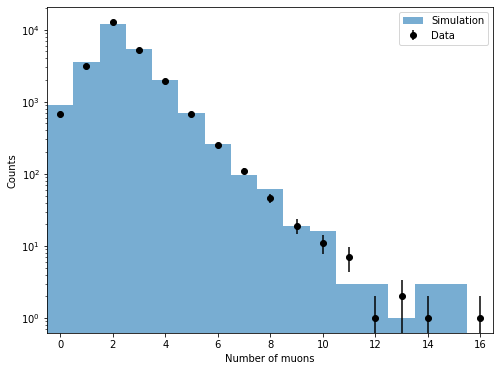

In [16]:
# let's plot the histogram

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
mc_counts = num_muons_dist.loc[num_muons_dist['sample']=='mc']
plt.bar(
    mc_counts['nMuon'], mc_counts['count'],
    label = 'Simulation', width=1, alpha=0.6
)

data_counts = num_muons_dist.loc[num_muons_dist['sample']=='data']
plt.errorbar(
    data_counts['nMuon'],data_counts['count'],
    yerr = np.sqrt(data_counts['count']),
    label = 'Data', color='black', fmt='o'
)
plt.xlim(-0.5,16.5)
plt.xlabel("Number of muons")
plt.ylabel("Counts")
plt.legend()
plt.semilogy()
plt.show()

We are interested in dimuon events, i.e. events having 2 muons. 

We can do this with:
- "plain dataframe"-like selections, e.g. `df[df.column > xyz]`
- `filter` 
- `where`
- SQL-like statements

In [17]:
# select only events with two muons in a "plain dataframe" style
df[df['nMuon']==2].show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{65.955784364436...|    2|  data|
|[{14.860828916586...|    2|  data|
|[{11.205213649577...|    2|  data|
+--------------------+-----+------+
only showing top 5 rows



In [18]:
from pyspark.sql.functions import col

# use a where statement on the column objects from spark
df.where(col('nMuon')==2).show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{65.955784364436...|    2|  data|
|[{14.860828916586...|    2|  data|
|[{11.205213649577...|    2|  data|
+--------------------+-----+------+
only showing top 5 rows



In [19]:
# use a where statement on the content of the dataframe
dimuon_df = df.where(df['nMuon']==2)
dimuon_df.show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{65.955784364436...|    2|  data|
|[{14.860828916586...|    2|  data|
|[{11.205213649577...|    2|  data|
+--------------------+-----+------+
only showing top 5 rows



In [ ]:
# use a filter statement on the content of the dataframe
df.filter(df['nMuon']==2).show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{65.955784364436...|    2|  data|
|[{14.860828916586...|    2|  data|
|[{11.205213649577...|    2|  data|
+--------------------+-----+------+
only showing top 5 rows



In [ ]:
# create a SQL-like view (a "table") of the records 
df.createOrReplaceTempView("dimuon_df_table")

# use plain SQL to filter the events with a SELECT statement
sqlDF = spark.sql("SELECT * FROM dimuon_df_table WHERE nMuon = 2")
sqlDF.show(5)

+--------------------+-----+------+
|               Muons|nMuon|sample|
+--------------------+-----+------+
|[{17.492634165117...|    2|  data|
|[{11.518019014184...|    2|  data|
|[{65.955784364436...|    2|  data|
|[{14.860828916586...|    2|  data|
|[{11.205213649577...|    2|  data|
+--------------------+-----+------+
only showing top 5 rows



At this stage the Dataset is not flat (we have nested content in the Muons column). 

In [ ]:
# dataset is not flat
dimuon_df.printSchema()

root
 |-- Muons: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- E: double (nullable = true)
 |    |    |-- charge: long (nullable = true)
 |    |    |-- px: double (nullable = true)
 |    |    |-- py: double (nullable = true)
 |    |    |-- pz: double (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- sample: string (nullable = true)



Now we can make our dataset flat for further processing: in this way we will be able to perform operations between the columns.

A new column can be created by using `withColumn(name, func)` where `func` is a function taking as input one or more columns. An arbitrary complex function can be used to produce the new column: for example we can define a **User Defined Function (UDF)** which will be applied to every row of the dataframe. 

In [21]:
# create columns for the two muons

# select()     projects a set of expressions and returns a new DataFrame
# withColumn() creates a new table attribute from the given column
# drop()       removes columns from the table
dimuon_flat = (
    # keep only sample/nMuon/Muons[0]/Muons[1] from the table
    dimuon_df.select([col('sample'), col('nMuon'), col('Muons')[0], col('Muons')[1]]) 
    # create a number of additional columns from the Muons[0/1] nested attributes
    .withColumn('E1', col('Muons[0].E'))
    .withColumn('px1', col('Muons[0].px'))
    .withColumn('py1', col('Muons[0].py'))
    .withColumn('pz1', col('Muons[0].pz'))
    .withColumn('c1',  col('Muons[0].charge'))
    .withColumn('E2',  col('Muons[1].E'))
    .withColumn('px2', col('Muons[1].px'))
    .withColumn('py2', col('Muons[1].py'))
    .withColumn('pz2', col('Muons[1].pz'))
    .withColumn('c2',  col('Muons[1].charge'))
    # remove the original Muons[0] and Muons[1] nested attributes
    .drop('Muons[0]', 'Muons[1]')
)

dimuon_flat.printSchema()

root
 |-- sample: string (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- E1: double (nullable = true)
 |-- px1: double (nullable = true)
 |-- py1: double (nullable = true)
 |-- pz1: double (nullable = true)
 |-- c1: long (nullable = true)
 |-- E2: double (nullable = true)
 |-- px2: double (nullable = true)
 |-- py2: double (nullable = true)
 |-- pz2: double (nullable = true)
 |-- c2: long (nullable = true)



We can now continue with our work and select only the events where the two muons have opposite charge (column `c1` and `c2`)

In [22]:
# select candidates with opposite charge muons
dimuon_flat = dimuon_flat.where(dimuon_flat['c1']==-dimuon_flat['c2'])
dimuon_flat.count()

18827

To compute the invariant mass of the two candidate muons we need first to compute the four-momentum of the parent particle 

$$
p = \left(E_1+E_2,\quad p_{x,1}+p_{x,2},\quad p_{y,1}+p_{y,2},\quad p_{z,1}+p_{z,2}\right) = (E,\, \mathbf{p})
$$

Create four new columns in the dataframe, one per each coordinate

In [23]:
# create new columns for the four momentum
dimuon_flat = (dimuon_flat
                .withColumn('E', col('E1')+col('E2'))
                .withColumn('px', col('px1')+col('px2'))
                .withColumn('py', col('py1')+col('py2'))
                .withColumn('pz', col('pz1')+col('pz2'))
)

dimuon_flat.printSchema()

root
 |-- sample: string (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- E1: double (nullable = true)
 |-- px1: double (nullable = true)
 |-- py1: double (nullable = true)
 |-- pz1: double (nullable = true)
 |-- c1: long (nullable = true)
 |-- E2: double (nullable = true)
 |-- px2: double (nullable = true)
 |-- py2: double (nullable = true)
 |-- pz2: double (nullable = true)
 |-- c2: long (nullable = true)
 |-- E: double (nullable = true)
 |-- px: double (nullable = true)
 |-- py: double (nullable = true)
 |-- pz: double (nullable = true)



From the 4-momentum of the candidate we can compute the invariant mass as

$$
M = \sqrt{p\cdot p} =  \sqrt{(E^2 - \|\mathbf{p}\|^2)} = \sqrt{(E^2 - (px^2 + py^2 + pz^2)}
$$

In [25]:
# compute invariant mass
from pyspark.sql.functions import sqrt

dimuon_flat = dimuon_flat.withColumn('M', sqrt(col('E')**2-(col('px')**2+col('py')**2+col('pz')**2)))

# persist the dataframe in memory
dimuon_flat = dimuon_flat.persist()

# show the first 5 elements of the mass (M) attribute
dimuon_flat.select('M').show(5)


+------------------+
|                 M|
+------------------+
|27.915489438238453|
|113.64685563213851|
| 1.587766097105187|
|23.723239249480446|
|0.7389114718977652|
+------------------+
only showing top 5 rows



It is possible to obtain the same result using a UDF

In [36]:
from pyspark.sql.functions import udf
import math

# obtain the same result using udf
#    create a UDF that takes as inputs E, px, py, pz and returns the invariant mass
@udf('float')
def invariant_mass(E, px, py, pz):
    return math.sqrt(E**2-(px**2+py**2+pz**2))

# apply the UDF by simply calling it with the proper columns inputs (e.g. col('E') )
dimuon_flat.select(
    invariant_mass(col('E'), col('px'), col('py'), col('pz'))
    ).show(5)


+-----------------------------+
|invariant_mass(E, px, py, pz)|
+-----------------------------+
|                     27.91549|
|                    113.64686|
|                     1.587766|
|                     23.72324|
|                   0.73891145|
+-----------------------------+
only showing top 5 rows



Similarly, we can use **Pandas UDFs**. 

This allows to process pyspark's dataframes as Pandas dataframes and Pandas series.

They result particularly efficient in the grouped maps, i.e. by appling a function after a groupby. 

More on this can be found [here](https://spark.apache.org/docs/latest/api/python/user_guide/arrow_pandas.html#grouped-map). 

In [42]:
from pyspark.sql.functions import pandas_udf

# obtain the same result using a pandas udf
#    create a UDF that takes as inputs the Pandas Series for E, px, py, pz 
#    and returns the Pandas Series for the invariant mass
@pandas_udf('float')
def invariant_mass_udf(
    E: pd.Series,
    px: pd.Series,
    py: pd.Series,
    pz: pd.Series
) -> pd.Series:
    return np.sqrt(E**2-(px**2+py**2+pz**2))

# apply the Pandas UDF 
#   rename the output by using the .alias("new name") method
dimuon_flat.select(
    invariant_mass_udf(col('E'), col('px'), col('py'), col('pz')).alias('M pandas udf')
).show(5)


+------------+
|M pandas udf|
+------------+
|    27.91549|
|   113.64686|
|    1.587766|
|    23.72324|
|  0.73891145|
+------------+
only showing top 5 rows



Compute the mean energy for different groups

In [39]:
# compute mean energy for each sample
(
    dimuon_flat.select(col('sample'), col('E'))
    .groupBy('sample')
    .mean()
    .show()
)

+------+-----------------+
|sample|           avg(E)|
+------+-----------------+
|    mc|77.57125860575734|
|  data|81.11666603913991|
+------+-----------------+



In [43]:
# obtain the same results with a Pandas UDF 

@pandas_udf('float')
def mean_udf(
    E: pd.Series
) -> float:
    return np.mean(E)

(
    dimuon_flat.select(col('sample'), col('E'))
    .groupBy('sample')
    .agg(mean_udf(col('E'))) # aggregator function
    .show()
)

+------+-----------+
|sample|mean_udf(E)|
+------+-----------+
|  data|   81.11667|
|    mc|   77.57126|
+------+-----------+



## (Re-)Discovering particles

Now that all the interesting quantities have been computed we can use them to perform the analysis.

For example, let's plot the invariant mass of the dimuon system.

In [44]:
# compute the histogram of M
bins, counts = dimuon_flat.select('M') \
                          .rdd \
                          .map(lambda x: x.M) \
                          .histogram(list(np.arange(0,115,0.5)))

In [47]:
# compute it for each sample
histogram_results = {}
for sample in ['mc', 'data']:  
    histogram_results[sample] = {}
    
    bins, count = (
        dimuon_flat.where(col('sample')==sample)
        .select('M')
        .rdd 
        .map(lambda x: x.M) 
        .histogram(list(np.arange(0,115,0.5)))
    )
    histogram_results[sample]['bins']=bins
    histogram_results[sample]['counts']=count

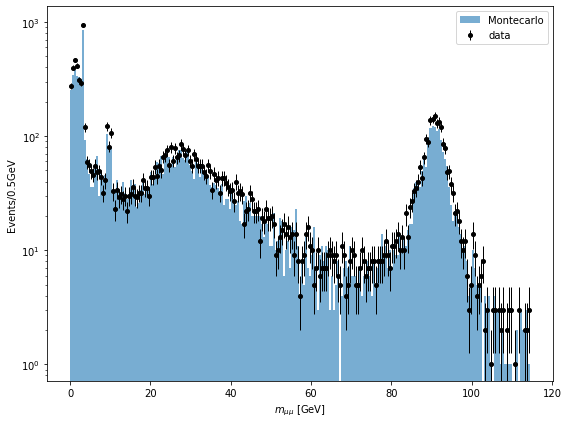

In [48]:
plt.figure(figsize=(8,6))

mc_res = histogram_results['mc']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='Montecarlo', alpha=0.6
)

data_res = histogram_results['data']
bin_centers = data_res['bins'][:-1] + np.diff(data_res['bins'])/2

plt.errorbar(
    bin_centers, data_res['counts'], yerr=np.sqrt(data_res['counts']),
    fmt='o', ms=4, lw=1, color='black', label='data'
)

plt.xlabel("$m_{\mu \mu}$ [GeV]")
plt.ylabel("Events/0.5GeV")
plt.legend()
plt.semilogy()
plt.tight_layout()
plt.show()

In the range 70-120 GeV it appears there is a large resonance, we can histogram the data in that range to see it better.

In [49]:
histogram_results = {}
for sample in ['mc', 'data']:
    histogram_results[sample] = {}
    
    # evaluate the new histograms here in the range 80-100
    bins, counts = """ --- """
    
    histogram_results[sample]['bins'] = bins
    histogram_results[sample]['counts'] = counts
    
plt.figure(figsize=(8,6))

mc_res = histogram_results['mc']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='Montecarlo', alpha=0.6
)

data_res = histogram_results['data']
bin_centers = data_res['bins'][:-1] + np.diff(data_res['bins'])/2

plt.errorbar(
    bin_centers, data_res['counts'], yerr=np.sqrt(data_res['counts']),
    fmt='o', ms=4, lw=1, color='black', label='data'
)

plt.xlabel("$m_{\mu \mu}$ [GeV]")
plt.ylabel("Events/0.5GeV")
plt.legend()
#plt.semilogy()
plt.tight_layout()
plt.show()

ValueError: too many values to unpack (expected 2)

We can try to perform some selection, to improve the quality of the signal and remove background. To do this we can try look at candidates with a large transverse momentum 

$$
p_T = \sqrt{p_x^2 + p_y^2}
$$

create a colum with name "energetic" and for each row set the value to `True` if $p_T\geq 30$ Gev. Plot then the results and see if there is any improvement. You can compare just the data or montecarlo. 

This can be achieved in spark using `when()` and `otherwise()`.

In [ ]:
# create a udf to evaluate the dimuon candidate pT


In [ ]:
from pyspark.sql.functions import when

dimuon_flat = dimuon_flat.withColumn("highpt", when(dimuon_flat.highpt>30,True).otherwise(False) )

In [ ]:
dimuon_flat['sample','M','highpt'].show(5)

In [ ]:
def compute_histogram(dataset, column):
    histogram_results = {}
    for sample in ['mc', 'data']:
        histogram_results[sample] = {}

        # create the invariant mass histogram in the range 70-115
        bins, counts = """ --- """

        histogram_results[sample]['bins'] = bins
        histogram_results[sample]['counts'] = counts
        
    return histogram_results
        
# compute two histograms:
#   - one for the energetic (highpt) cadidates
#   - another one for the non-energetic (not highpt) cadidates
is_energetic = """ --- """
not_energetic = """ --- """
 
plt.figure(figsize=(8,6))

mc_res = not_energetic['mc']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='Not energetic', alpha=0.6
)

mc_res = is_energetic['mc']
bin_centers = mc_res['bins'][:-1] + np.diff(mc_res['bins'])/2
plt.hist(
    bin_centers, weights=mc_res['counts'], bins=mc_res['bins'],
    label='Energetic', alpha=0.6
)

plt.xlabel("$m_{\mu \mu}$ [GeV]")
plt.ylabel("Events/0.5GeV")
plt.legend()
#plt.semilogy()
plt.tight_layout()
plt.show()

## Stop worker and master

In [ ]:
sc.stop()
spark.stop()

In [ ]:
%%script bash --no-raise-error

if [[ "$CLUSTER_TYPE" != "docker_cluster" ]]; then
    # stop worker 
    $SPARK_HOME/sbin/stop-worker.sh
    
    # start master
    $SPARK_HOME/sbin/stop-master.sh
fi